tsne visualization


https://learnopencv.com/t-sne-for-feature-visualization/

https://github.com/CannyLab/tsne-cuda

```
@article{chan2019gpu,
  title={GPU accelerated t-distributed stochastic neighbor embedding},
  author={Chan, David M and Rao, Roshan and Huang, Forrest and Canny, John F},
  journal={Journal of Parallel and Distributed Computing},
  volume={131},
  pages={1--13},
  year={2019},
  publisher={Elsevier}
}
```

In [1]:
# conda install tsnecuda -c conda-forge
# optimized tsne using cuda gpus
from tsnecuda import TSNE # (2D only)

import os
import numpy as np

import torch
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt

load pretrained resnet 50 model

In [19]:
model_path = '../main_resnet50/FEC_resnet50_trained_face_images_80_10_10.pt'
data_dir = '../data/face_images_80_10_10/train'
num_classes = 7

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f'using device: {device}')

# load the trained model
model = models.resnet50(num_classes=num_classes)
# transfer model to gpu if available
model = model.to(device)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
# set model to evaluation mode
model.eval()

using device: cpu


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

load images and apply data preprocessing

In [20]:
data_transforms = transforms.Compose([
	transforms.Resize(size=(224, 224)),
	transforms.ToTensor(),
	# use ImageNet standard mean and std dev for transfer learning
	transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# load test dataset and create dataloader
data_set = ImageFolder(data_dir, transform=data_transforms)
data_loader = DataLoader(data_set, batch_size=len(data_set), shuffle=True)

pass images into model, and get features from last layer

In [23]:
def get_representations(model, device, data_loader):
	outputs = []
	intermediates = []
	labels = []

	model.eval()
	with torch.no_grad():
		for images, batch_labels in data_loader:
			images = images.to(device)
			batch_labels = batch_labels.to(device)

			y_pred = model(images)

			outputs.append(y_pred.cpu())
			labels.append(batch_labels.cpu())
	outputs = torch.cat(outputs, dim=0)
	labels = torch.cat(labels, dim=0)

	return outputs, labels.numpy()

outputs, labels = get_representations(model, device, data_loader)

In [24]:
# use tsne to fit model features to get embeddings in 2D
X_emb_2D = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(outputs)

Initializing cuda handles... done.
KNN Computation... done.
Computing Pij matrix... 
done.
Initializing low dim points... done.
Initializing CUDA memory... done.
[Step 0] Avg. Gradient Norm: 0.00431778
[Step 10] Avg. Gradient Norm: 0.000249046
[Step 20] Avg. Gradient Norm: 0.000846805
[Step 30] Avg. Gradient Norm: 0.0179475
[Step 40] Avg. Gradient Norm: 0.891344
[Step 50] Avg. Gradient Norm: 17.3701
[Step 60] Avg. Gradient Norm: 2.81763
[Step 70] Avg. Gradient Norm: 2.63988
[Step 80] Avg. Gradient Norm: 2.41205
[Step 90] Avg. Gradient Norm: 1.79121
[Step 100] Avg. Gradient Norm: 1.49179
[Step 110] Avg. Gradient Norm: 1.29028
[Step 120] Avg. Gradient Norm: 1.12441
[Step 130] Avg. Gradient Norm: 1.01607
[Step 140] Avg. Gradient Norm: 0.918223
[Step 150] Avg. Gradient Norm: 0.841575
[Step 160] Avg. Gradient Norm: 0.771885
[Step 170] Avg. Gradient Norm: 0.724991
[Step 180] Avg. Gradient Norm: 0.680932
[Step 190] Avg. Gradient Norm: 0.640193
[Step 200] Avg. Gradient Norm: 0.610289
[Step 210

In [26]:
# scale the embedding coordinates to [0, 1] range
def scale(x):
	# compute the distribution range
	value_range = (np.max(x) - np.min(x))

	# move the distribution so that it starts from zero
	# by extracting the minimal value from all its values
	starts_from_zero = x - np.min(x)

	# make the distribution fit [0; 1] by dividing by its range
	return starts_from_zero / value_range

# extract x and y coordinates of 2D t-SNE embeddings
tx = X_emb_2D[:, 0]
ty = X_emb_2D[:, 1]

tx = scale(tx)
ty = scale(ty)

Plot 2D t-SNE embeddings

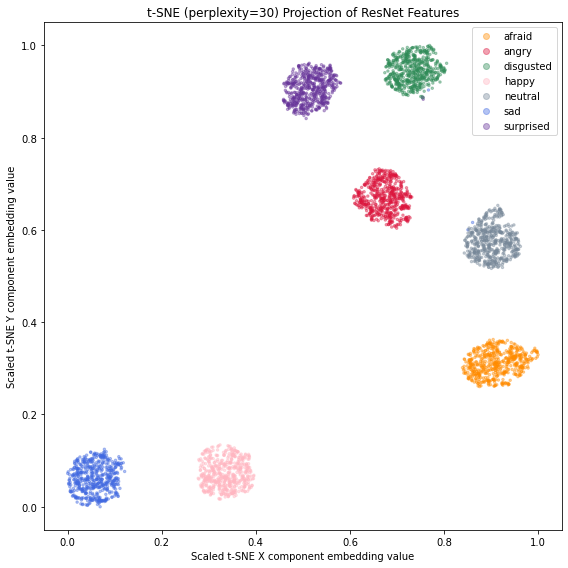

In [29]:
# Create the figure
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title=f't-SNE (perplexity={30}) Projection of ResNet Features')

colors= ['darkorange','crimson','seagreen','lightpink', 'lightslategray', 'royalblue', 'rebeccapurple']
    # Create the scatter
scatter = ax.scatter(
    tx,
    ty,
    c=labels,
    cmap=matplotlib.colors.ListedColormap(colors),
    alpha=0.4,
    s=6.0)

ax.legend(handles=scatter.legend_elements()[0], labels=list(data_set.class_to_idx.keys()), loc='best')

ax.set_xlabel('Scaled t-SNE X component embedding value')
ax.set_ylabel('Scaled t-SNE Y component embedding value')


plt.tight_layout()
# plt.savefig(f'tsne_2D_perp_{perplexity}.png')
plt.show()

fit to get 3D tsne embeddings (differnet library because previous one only supported 2D)

In [31]:
from tsne_torch import TorchTSNE as TSNE
X_emb_3D = TSNE(n_components=3, perplexity=50, n_iter=1000, verbose=True).fit_transform(outputs)

using cuda
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/3920 [00:00<?, ?it/s]

fitting...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
# extract x,y,z coordinates representing the embedding positions on t-SNE 3D plot
tx = X_emb_3D[:, 0]
ty = X_emb_3D[:, 1]
tz = X_emb_3D[:, 2]

# rescale coordinates to [0, 1] range
tx = scale(tx)
ty = scale(ty)
tz = scale(tz)

plot in 3D

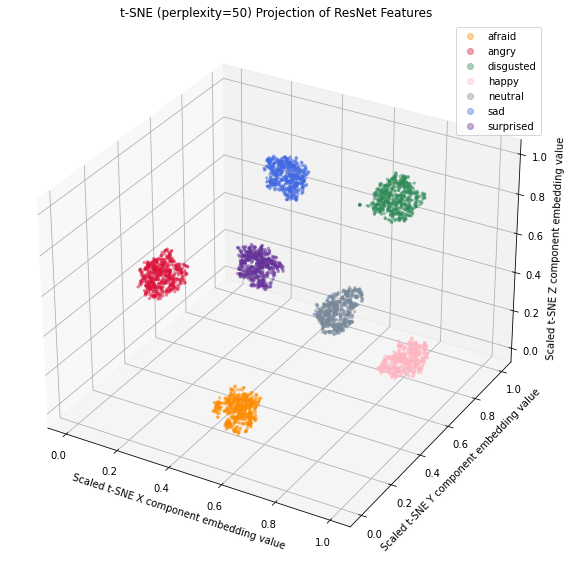

In [37]:
# Create the figure
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, projection='3d', title=f't-SNE (perplexity={50}) Projection of ResNet Features')

colors= ['darkorange','crimson','seagreen','lightpink', 'lightslategray', 'royalblue', 'rebeccapurple']
    # Create the scatter
scatter = ax.scatter(
        tx,
        ty,
        tz,
        c=labels,
        cmap=matplotlib.colors.ListedColormap(colors),
        alpha=0.4,
        s=6.0)

ax.legend(handles=scatter.legend_elements()[0], labels=list(data_set.class_to_idx.keys()), loc='best')

ax.set_xlabel('Scaled t-SNE X component embedding value')
ax.set_ylabel('Scaled t-SNE Y component embedding value')
ax.set_zlabel('Scaled t-SNE Z component embedding value')


plt.tight_layout()
# plt.savefig(f'tsne_3D_perp_{perplexity}.png')
plt.show()